### 1. Import Required Packages

In [1]:
import math
import json
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

C:\Users\ASUS\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\ASUS\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\ASUS\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\ASUS\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (

### 2. Read dataset from exported json file

In [2]:
df = pd.read_json('C:/Users/ASUS/BANGKIT/TokoLitik/data.json')
df["date"] = df["date"].dt.date

### 3. Data Preprocessing

#### - PREPARE DATA

In [3]:
productFile = open("C:/Users/ASUS/BANGKIT/TokoLitik/product.json")
product = json.load(productFile)

transactionFile = open("C:/Users/ASUS/BANGKIT/TokoLitik/transaction.json")
transaction = json.load(transactionFile)

In [4]:
#change date field into datetime format

df["date"] = pd.to_datetime(df["date"])

In [5]:
# change every data in date field as the first date of each month for plotting the monthly sales
df_temp = df.copy()
df_temp["date"] = df_temp["date"].dt.year.astype("str") + '-' + df["date"].dt.month.astype("str") + '-01'
df_temp['date'] = pd.to_datetime(df_temp['date'])
print("Total rows: ", df_temp.shape[0])

Total rows:  6568


#### - Change Daily Sales Data into Monthly Sales

In [6]:
# groupby date and sum the sales item
df_monthly = df_temp.copy()
df_monthly = df_monthly.groupby('date').daily_sales.sum().reset_index()
df_monthly.rename(columns={'daily_sales':'monthly_sales'}, inplace=True)
print("Total rows: ", df_monthly.shape[0])

# print all rows in dataframe
pd.set_option("display.max_rows", None, "display.max_columns", None)
print(df_monthly)

Total rows:  72
         date  monthly_sales
0  2015-01-01           8371
1  2015-02-01           7642
2  2015-03-01           8224
3  2015-04-01           8247
4  2015-05-01           8466
5  2015-06-01           7477
6  2015-07-01           6524
7  2015-08-01           5153
8  2015-09-01           4186
9  2015-10-01           2699
10 2015-11-01           2248
11 2015-12-01           1139
12 2016-01-01           9292
13 2016-02-01           9619
14 2016-03-01           8683
15 2016-04-01           9268
16 2016-05-01           9013
17 2016-06-01           8859
18 2016-07-01           8184
19 2016-08-01           7434
20 2016-09-01           6427
21 2016-10-01           4971
22 2016-11-01           2953
23 2016-12-01           1145
24 2017-01-01           9521
25 2017-02-01           9782
26 2017-03-01          10069
27 2017-04-01          10372
28 2017-05-01           9297
29 2017-06-01           9555
30 2017-07-01           7393
31 2017-08-01           6531
32 2017-09-01           500

#### - Plot Monthly Sales Data

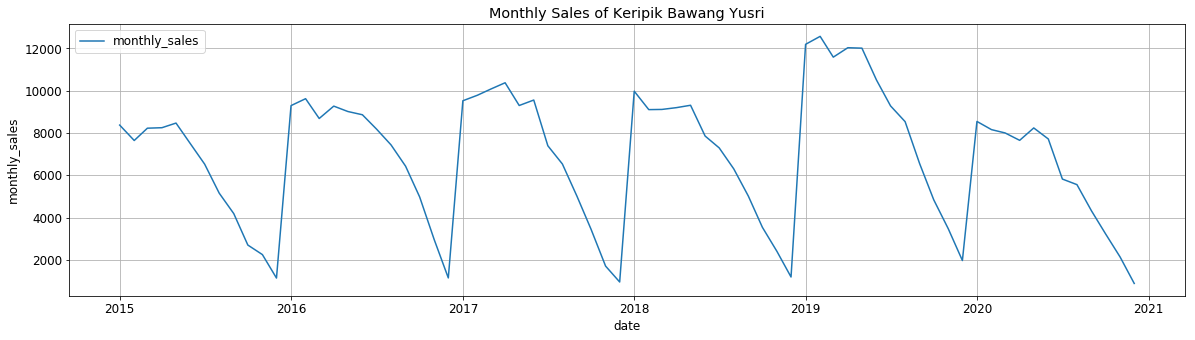

In [7]:
plt.rc("font", size=12)
fig, ax = plt.subplots(figsize=(20,5))

# specify how our line should look like
ax.plot(df_monthly['date'], df_monthly['monthly_sales'], label="monthly_sales")

# same as above
ax.set_xlabel("date")
ax.set_ylabel("monthly_sales")
ax.set_title("Monthly Sales of {}".format(product["productName"]))
ax.grid(True)
ax.legend(loc="upper left")

#### - Data Transformation

As we can see, the data in the previous graph is not stationary yet and has a decreasing trend in the last few months. Here, we are using difference method to make the data stationary

##### Ide dasar dari stasioneritas adalah hukum probabilitas mengharuskan proses tidak berubah sepanjang waktu, dengan kata lain proses dalam keadaan setimbang secara statistik (Cryer, 1986). Sekumpulan data dinyatakan stasioner jika nilai rata-rata dan varian dari data time series tersebut tidak mengalami perubahan secara sistematik sepanjang waktu, atau sebagian ahli menyatakan rata-rata dan variannya konstan (nachrowi dan haridus usman, 2006).

In [8]:
# create a new dataframe to model the difference
df_diff = df_monthly.copy()

# implement the difference technique
df_diff["prev_month_sales"] = df_diff['monthly_sales'].shift(1)

# drop the null values and calculate the difference 
df_diff = df_diff.dropna()
df_diff['diff'] = (df_diff['monthly_sales'] - df_diff['prev_month_sales'])

#### - Plot Stationary Data

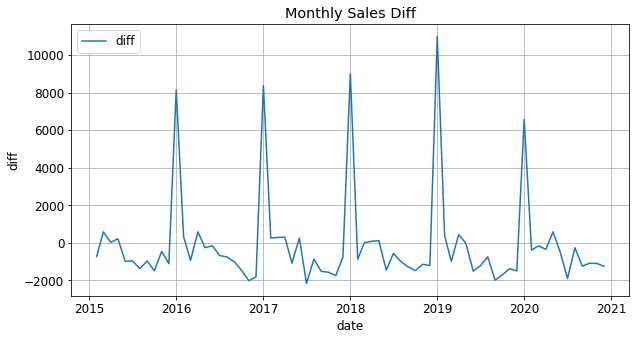

In [9]:
plt.rc("font", size=12)
fig, ax = plt.subplots(figsize=(10,5))

# specify how our line should look like
ax.plot(df_diff['date'], df_diff['diff'], label="diff")

# same as above
ax.set_xlabel("date")
ax.set_ylabel("diff")
ax.set_title("Monthly Sales Diff")
ax.grid(True)
ax.legend(loc="upper left")


As we can see, the graph looks stationary after differentiating. Next we need to use our previous monthly sales data to predict the next ones. I'll use 12 look-back period for this sample

In [10]:
#create dataframe for transformation from time series to supervised
df_supervised = df_diff.drop(['prev_month_sales'],axis=1)

#adding lags
for i in range(1,13):
    field_name = 'lag_' + str(i)
    df_supervised[field_name] = df_supervised['diff'].shift(i)

#drop null values
df_supervised = df_supervised.dropna().reset_index(drop=True)

In [11]:
# Import statsmodels.formula.api
import statsmodels.formula.api as smf

# Define the regression formula
model = smf.ols(formula='diff ~ lag_1 + lag_2 + lag_3 + lag_4 + lag_5 + lag_6 + lag_7 + lag_8 + lag_9 + lag_10 + lag_11 + lag_12', data=df_supervised)

# Fit the regression
model_fit = model.fit()

# Extract the adjusted r-squared
regression_adj_rsq = model_fit.rsquared_adj
# print(regression_adj_rsq)

In [12]:
 #import MinMaxScaler and create a new dataframe for LSTM model
from sklearn.preprocessing import MinMaxScaler

df_model = df_supervised.drop(['date','monthly_sales'],axis=1)
print("features shape: ", df_model.shape[0])
df_model.head()

features shape:  59


,diff,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12
0,327.0,8153.0,-1109.0,-451.0,-1487.0,-967.0,-1371.0,-953.0,-989.0,219.0,23.0,582.0,-729.0
1,-936.0,327.0,8153.0,-1109.0,-451.0,-1487.0,-967.0,-1371.0,-953.0,-989.0,219.0,23.0,582.0
2,585.0,-936.0,327.0,8153.0,-1109.0,-451.0,-1487.0,-967.0,-1371.0,-953.0,-989.0,219.0,23.0
3,-255.0,585.0,-936.0,327.0,8153.0,-1109.0,-451.0,-1487.0,-967.0,-1371.0,-953.0,-989.0,219.0
4,-154.0,-255.0,585.0,-936.0,327.0,8153.0,-1109.0,-451.0,-1487.0,-967.0,-1371.0,-953.0,-989.0


In [13]:
df_model.tail(6)

,diff,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12
53,-1895.0,-522.0,586.0,-349.0,-157.0,-387.0,6575.0,-1498.0,-1371.0,-1707.0,-1989.0,-744.0,-1225.0
54,-263.0,-1895.0,-522.0,586.0,-349.0,-157.0,-387.0,6575.0,-1498.0,-1371.0,-1707.0,-1989.0,-744.0
55,-1241.0,-263.0,-1895.0,-522.0,586.0,-349.0,-157.0,-387.0,6575.0,-1498.0,-1371.0,-1707.0,-1989.0
56,-1088.0,-1241.0,-263.0,-1895.0,-522.0,586.0,-349.0,-157.0,-387.0,6575.0,-1498.0,-1371.0,-1707.0
57,-1095.0,-1088.0,-1241.0,-263.0,-1895.0,-522.0,586.0,-349.0,-157.0,-387.0,6575.0,-1498.0,-1371.0
58,-1248.0,-1095.0,-1088.0,-1241.0,-263.0,-1895.0,-522.0,586.0,-349.0,-157.0,-387.0,6575.0,-1498.0


#### - Export features to csv file

In [ ]:
df_model.to_csv(r"C:/Users/ASUS/BANGKIT/TokoLitik/model_features.csv", index = False, header=True)

In [14]:
def data_preparation(data, steps):
    x, y = [], []
    for i in range(len(data)):
        data_rng = i + steps
        if data_rng > len(data)-1:
            break
        x_temp, y_temp = data[i:data_rng], data[data_rng]
        x.append(x_temp)
        y.append(y_temp)
    return np.array(x), np.array(y)

In [17]:
data = df_model.values
steps = 6

In [18]:
x_data, y_data = data_preparation(data, steps)

#### - Split Train and Test Set

In [ ]:
#split train and test set
train_set, test_set = df_model[0:-6].values, df_model[-6:].values
print(test_set)

In [ ]:
# apply MinMax Scaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(train_set)

In [ ]:
# transform train_set
train_set_scaled = scaler.transform(train_set)

In [ ]:
# transform test set
test_set_scaled = scaler.transform(test_set)

In [ ]:
x_train, y_train = train_set_scaled[:, :-1], train_set_scaled[:, -1:]
x_train = x_train.reshape(x_train.shape[0], 1, x_train.shape[1])


x_test, y_test = test_set_scaled[:, :-1], test_set_scaled[:, -1:]
x_test = x_test.reshape(x_test.shape[0], 1, x_test.shape[1])
print(x_train.shape)
print(y_train.shape)

### 4. LSTM MODEL

In [ ]:
import tensorflow as tf

model = tf.keras.models.Sequential([
            tf.keras.layers.LSTM(50, activation="relu", return_sequences=True, input_shape=(1, 12)),
            tf.keras.layers.LSTM(50, activation="relu"),
            tf.keras.layers.Dense(1)
        ])

model.compile(loss="mean_squared_error", optimizer="adam")
model.fit(x_train, y_train, epochs=100, batch_size=1, verbose=1)

In [ ]:
y_pred = model.predict(x_test, batch_size=1)

In [ ]:
y_pred

In [ ]:
y_test

In [ ]:
#reshape y_pred
y_pred = y_pred.reshape(y_pred.shape[0], 1, y_pred.shape[1])

len(y_pred)
#rebuild test set for inverse transform
pred_test_set = []

for index in range(0,len(y_pred)):
    pred_test_set.append(np.concatenate([y_pred[index],x_test[index]],axis=1))

#reshape pred_test_set
pred_test_set = np.array(pred_test_set)
pred_test_set = pred_test_set.reshape(pred_test_set.shape[0], pred_test_set.shape[2])

#inverse transform
pred_test_set_inverted = scaler.inverse_transform(pred_test_set)
print(pred_test_set_inverted)

In [ ]:
#create dataframe that shows the predicted sales
result_list = []
sales_dates = list(df_monthly[-7:].date)
act_sales = list(df_monthly[-7:].monthly_sales)

for index in range(0,len(pred_test_set_inverted)):
    result_dict = {}
    result_dict['pred_value'] = int(pred_test_set_inverted[index][0] + act_sales[index])
    result_dict['date'] = sales_dates[index+1]
    result_list.append(result_dict)
df_result = pd.DataFrame(result_list)
df_result.head(6)

In [ ]:
df_monthly.tail(6)

### 5. Plotting Predicted data

Test set is the last 6 data in the monthly sales (2020-7-01 to 2020-12-01). We have passed the test set above in order to test how good our predict model is. The more similar the actual data to the predicted results, the better our model is.

Here we will see how the predicted last 6 months drawn and compared with the actual 6 data in the monthly sales

In [ ]:
df_sales_pred = pd.merge(df_monthly, df_result, on="date", how="left")

plt.rc("font", size=12)
fig, ax = plt.subplots(figsize=(10,5))

# specify how our line should look like
ax.plot(df_sales_pred['date'], df_sales_pred['monthly_sales'], label="actual")
ax.plot(df_sales_pred['date'], df_sales_pred['pred_value'], label="predicted")

# same as above
ax.set_xlabel("date")
ax.set_ylabel("sales")
ax.set_title("Sales Prediction")
ax.grid(True)
ax.legend(loc="upper left")

## Now let's check how our entire dataset fit the model

In [ ]:
dataset_values = df_model[1:].values
dataset_scaler = MinMaxScaler(feature_range=(0,1))
dataset_scaler = dataset_scaler.fit(dataset_values)

test_set_scaled = dataset_scaler.transform(dataset_values)
dataset_test = test_set_scaled[:, 1:]
dataset_test = dataset_test.reshape(dataset_test.shape[0], 1, dataset_test.shape[1])
print(dataset_test.shape)

In [ ]:
y_pred = model.predict(dataset_test, batch_size=1)

In [ ]:
y_pred

In [ ]:
#reshape y_pred
y_pred = y_pred.reshape(y_pred.shape[0], 1, y_pred.shape[1])

len(y_pred)
#rebuild test set for inverse transform
pred_test_set = []

for index in range(0,len(y_pred)):
    pred_test_set.append(np.concatenate([y_pred[index],dataset_test[index]],axis=1))

#reshape pred_test_set
pred_test_set = np.array(pred_test_set)
pred_test_set = pred_test_set.reshape(pred_test_set.shape[0], pred_test_set.shape[2])

#inverse transform
pred_test_set_inverted = scaler.inverse_transform(pred_test_set)
len(pred_test_set_inverted)

In [ ]:
#create dataframe that shows the predicted sales
result_list = []
sales_dates = list(df_monthly.date)
act_sales = list(df_monthly.monthly_sales)

for index in range(0,len(pred_test_set_inverted)):
    result_dict = {}
    result_dict['pred_value'] = int(pred_test_set_inverted[index][0] + act_sales[index])
    result_dict['date'] = sales_dates[index+1]
    result_list.append(result_dict)
df_result = pd.DataFrame(result_list)
df_result.head(6)

In [ ]:
df_sales_pred = pd.merge(df_monthly, df_result, on="date", how="left")

plt.rc("font", size=12)
fig, ax = plt.subplots(figsize=(10,5))

# specify how our line should look like
ax.plot(df_sales_pred['date'], df_sales_pred['monthly_sales'], label="actual")
ax.plot(df_sales_pred['date'], df_sales_pred['pred_value'], label="predicted")

# same as above
ax.set_xlabel("date")
ax.set_ylabel("sales")
ax.set_title("Sales Prediction")
ax.grid(True)
ax.legend(loc="upper left")

## Export Model

In [ ]:
saved_model_path = "C:/Users/ASUS/BANGKIT/TokoLitik/transaction_model.h5"

# save model
model.save(saved_model_path)